In [2]:
%%writefile Archivo_Datos.c
#include<stdio.h>
#include<stdlib.h>
#include<time.h>
// ---> argv[1]: Nombre del archivo a generar <---
// ---> argv[2]: numero de datos a generar    <---
int main(int argc, char*argv[]){
  FILE *fp;
  int n,*datos, i;
  
  n = atoi(argv[2]);
  fp = fopen(argv[1], "w");
  if(fp){
    srand(time(NULL));
    fprintf(fp,"%d\n",n);
    for(i=0;i<n;i++)
      fprintf(fp,"%d\n",rand()%100);
    
    fclose(fp);
  }
  
	return 0;
}


Writing Archivo_Datos.c


In [3]:
%%script bash
echo "Genera Archivo de Datos"
gcc Archivo_Datos.c -o Archivo_Datos -lm
./Archivo_Datos datos.dat 100000000

Genera Archivo de Datos


In [ ]:
%%writefile QuickSort.c
#include <stdlib.h>
#include <stdio.h>
#include <sys/time.h>

float time_diff(struct timeval *start, struct timeval *end){
    return (end->tv_sec - start->tv_sec) + 1e-6*(end->tv_usec - start->tv_usec);
}
             
int compare(const void *_a, const void *_b) 
{
        int *a, *b;        
        a = (int *) _a;
        b = (int *) _b;
        return (*a - *b);
}

//  ■■■■
int main(int argc, char**argv) {
  FILE *myFile;
  int n, chunksize, i;
  int *Arreglo;

  struct timeval start;
  struct timeval end;
  gettimeofday(&start,NULL);

  myFile = fopen(argv[1], "r");
   if(!myFile){
    printf("ERROR: No se pudo abrir el archivo para lectura <%s>",argv[1]);
    return -1;
  }

  fscanf(myFile, "%i\n", &n); // numero de datos a leer
  printf("cantidad de números a ordenar: %i",n);

  Arreglo = (int*) malloc(n*sizeof(int));

  for (i=0; i < n; i++)
    fscanf(myFile, "%i\n", (Arreglo)+i);
  

    /*printf("\nArreglo Desordenado = {");
    for(i=0;i<n;i++)
      printf("%d, ", Arreglo[i]);
    printf("}");*/

  // ------aqui va el procesamiento a realizar con los datos

  qsort(Arreglo, n, sizeof(int), &compare);

    /*printf("\nArreglo ordenado = {");
    for(i=0;i<n;i++)
      printf("%d, ",Arreglo[i]);
    printf("}");*/

  gettimeofday(&end,NULL);

  printf("\nTiempo ejecutado en %f segundos", time_diff(&start, &end));
  
  free(Arreglo);
  return 0;
}

Overwriting QuickSort.c


In [ ]:
%%script bash
echo "Ordenamiento Rápido"
gcc QuickSort.c -o quicksort -lm
./quicksort datos.dat

Ordenamiento Rápido
cantidad de números a ordenar: 5000000
Tiempo ejecutado en 1.304776 segundos

In [ ]:
%%writefile Ordenamiento.c
#include <stdlib.h>
#include "mpi.h"
#include <stdio.h>
#include <math.h> // ceil()
#include <limits.h> // INT_MAX 

void mezcla(int* S_i, int chunksize2){
    
    int *aux = NULL;
    // Pedimos memoria al arreglo auxilar
    aux = (int*) malloc(chunksize2*sizeof(int));
    
    if(aux == NULL){
      printf("No hay memoria\n");   
      MPI_Abort(MPI_COMM_WORLD,99);  
    }
    
    // Hacemos la copia del arreglo
    for (int i=0; i<chunksize2/2;i++){
      aux[i]=S_i[i];
    }

    int a = 0; // Indice que recorre la primera parte del arreglo
    int b = chunksize2 /2; // Indice que recorre la segunda parte del arreglo
    int i=0;

    // Mientras algun índice no llegue a la parte final que recorren

    while (a < chunksize2/2 && b < chunksize2){
        if(aux[a] <= S_i[b]){
            S_i[i] = aux[a];
            a++;
        }else{
            S_i[i] = S_i[b];
            b++;
        }
        i++;
    }
    // Si el indice b llegó al final de su arreglo

    if(b == chunksize2){
        // Asignamos los numeros restantes
        while(i < chunksize2){
            S_i[i] = aux[a];
            a++;
            i++;
        }
    }
    free(aux);
}

int compare(const void *_a, const void *_b){
  int *a, *b;
  a = (int *) _a;
  b = (int *) _b;
  return (*a - *b);
}

int read_array(char* fname, int **arr, int np) {
  FILE *myFile;
  unsigned int i, n, chunksize, faltantes;

  myFile = fopen(fname, "r");
  if(!myFile){
    printf("ERROR: No se pudo abrir el archivo para lectura %s",fname);
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  fscanf(myFile, "%i\n", &n); // numero de datos a leer

  chunksize = ceil(n*1.0 / np);
  faltantes = np*chunksize - n;

  *arr = (int *) malloc((chunksize*np)*sizeof(int));
  if (*arr == NULL) {
    printf("Memoria insuficiente\n");
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  for ( i=0; i < n; i++)
    fscanf(myFile, "%i\n", (*arr)+i);

  for ( i=n; i < n + faltantes; i++) //<--- Dummys
    (*arr)[i] = INT_MAX;

  return n;
}

int main(int argc, char**argv) {
  int rank, np, root, faltantes;
  unsigned int n, chunksize, i;
  double t1, t2;
  int *Arreglo, *S_i;

  MPI_Init(&argc, &argv);

  MPI_Comm_size(MPI_COMM_WORLD, &np); // Numero total de procesos
  MPI_Comm_rank(MPI_COMM_WORLD, &rank); // Valor de nuestro identificador

  MPI_Barrier(MPI_COMM_WORLD);  // sincronización
  t1 = MPI_Wtime();

  // Root es el último
  root = np - 1;

  // <--- toma de tiempo 1
  if (rank == root){ // Lee los datos del archivo
    n = read_array(argv[1], &Arreglo, np);
    chunksize = ceil(n*1.0 / np);
    faltantes = np*chunksize - n;    

/*
    printf("\nArreglo = {");
    for(i=0;i<n;i++)
      printf("%d, ", Arreglo[i]);
    printf("}");
*/
  }
  
  // Comunica longitud de los chunks
  MPI_Bcast(&chunksize, 1, MPI_UNSIGNED, root, MPI_COMM_WORLD);
  
  // Pide memoria del doble de dicha longitud para poder ordenar
  S_i = (int *) malloc(2*chunksize*sizeof(int));
  if (S_i == NULL) {
    printf("Memoria insuficiente\n");
    MPI_Abort(MPI_COMM_WORLD, 99);
  }

  MPI_Scatter(Arreglo, chunksize, MPI_INT, S_i, chunksize, MPI_INT, root, MPI_COMM_WORLD);
/*
  if (rank==0) {
    for(i=0;i<chunksize;i++)
      printf("%d\t ", S_i[i]);
  }*/

  // ------aqui va el procesamiento a realizar con los datos

  qsort(  S_i, chunksize,sizeof(int), &compare );
  printf("[%d]chunksize:%d\n",rank,chunksize);
  for(i=1;i<=ceil(np/2.0);i++){
    if(rank%2==1) {
         MPI_Send( S_i, chunksize, MPI_INT, rank-1, 10, MPI_COMM_WORLD );
         MPI_Recv( S_i, chunksize, MPI_INT, rank-1, 10, MPI_COMM_WORLD, MPI_STATUS_IGNORE );
    }

    if(rank%2==0 && rank!=np-1){
      MPI_Recv( S_i+chunksize, chunksize, MPI_INT, rank+1, 10, MPI_COMM_WORLD, MPI_STATUS_IGNORE );   
      mezcla(S_i, 2*chunksize); // <---- 
      MPI_Send(S_i+chunksize, chunksize, MPI_INT, rank+1, 10, MPI_COMM_WORLD);  
    }

    if(rank%2==0 && rank!=0) {
         MPI_Send( S_i, chunksize, MPI_INT, rank-1, 10, MPI_COMM_WORLD );
         MPI_Recv( S_i, chunksize, MPI_INT, rank-1, 10, MPI_COMM_WORLD, MPI_STATUS_IGNORE );
    }

    if(rank%2==1 && rank!=np-1){
      MPI_Recv( S_i+chunksize, chunksize, MPI_INT, rank+1, 10, MPI_COMM_WORLD, MPI_STATUS_IGNORE );   
      mezcla(S_i, 2*chunksize); // <---- 
      MPI_Send(S_i+chunksize, chunksize, MPI_INT, rank+1, 10, MPI_COMM_WORLD);  
    }
  }
  // ---------------------------------------------------------

  // Recolectar de nuevo los datos en el root e imprimir
  MPI_Gather(S_i, chunksize, MPI_INT, Arreglo, chunksize, MPI_INT, root, MPI_COMM_WORLD );
  // <--- toma de tiempo 2

  /*if( rank==root ){
    printf("\nArreglo ordenado = {");
    for(i=0;i<n;i++)
      printf("%d\t",Arreglo[i]);
    printf("}");
  }*/

  // ---------------------------------------------------------
  free(S_i);
  if (rank == root) free(Arreglo);

  MPI_Barrier(MPI_COMM_WORLD);
  t2 = MPI_Wtime();

  if(rank==root){
    printf("\n%d\t %.10f \n",np, t2-t1);
  }

  MPI_Finalize();
  return 0;
}

Overwriting Ordenamiento.c


In [ ]:
%%script bash
mpicc Ordenamiento.c -o Ordenamiento -lm
#rm datos.dat   
echo "Ordenamiento Rapido en Paralelo"
for i in $(seq 1 16)
do
    echo " ----- Usando $i procesos"
    mpirun --allow-run-as-root -np $i Ordenamiento datos.dat    
done

Ordenamiento Rapido en Paralelo
 ----- Usando 1 procesos
[0]chunksize:5000000

1	 1.3292347650 
 ----- Usando 2 procesos
[0]chunksize:2500000
[1]chunksize:2500000

2	 1.5907769590 
 ----- Usando 3 procesos
[0]chunksize:1666667
[2]chunksize:1666667
[1]chunksize:1666667

3	 2.4188988560 
 ----- Usando 4 procesos
[2]chunksize:1250000
[1]chunksize:1250000
[0]chunksize:1250000
[3]chunksize:1250000

4	 2.5911832350 
 ----- Usando 5 procesos
[3]chunksize:1000000
[1]chunksize:1000000
[2]chunksize:1000000
[4]chunksize:1000000
[0]chunksize:1000000

5	 3.3172552620 
 ----- Usando 6 procesos
[1]chunksize:833334
[0]chunksize:833334
[3]chunksize:833334
[5]chunksize:833334
[4]chunksize:833334
[2]chunksize:833334

6	 3.6205415810 
 ----- Usando 7 procesos
[5]chunksize:714286
[3]chunksize:714286
[0]chunksize:714286
[2]chunksize:714286
[1]chunksize:714286
[6]chunksize:714286
[4]chunksize:714286

7	 4.3121950600 
 ----- Usando 8 procesos
[5]chunksize:625000
[4]chunksize:625000
[1]chunksize:625000
[0]chun

In [ ]:
%matplotlib inline

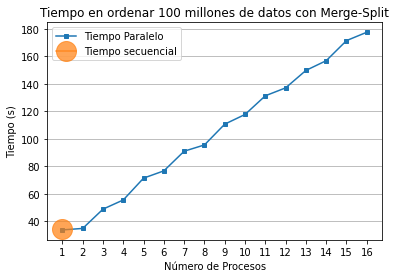

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
tiempo_secuencial = 34.095486

procesos = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
tiempos_ms = np.array([33.7450496740,34.8315266020,48.8471598560,55.5208529670,71.3873132160,
                       76.6653346670,90.9452396860,95.5078100360,110.6076294930,117.6506313260,
                       131.2223169430,136.9759305740,149.6576050840,156.7285753920,171.3213518920,177.4025252280]) 

fig, ax = plt.subplots()
ax.plot(procesos,tiempos_ms,marker='s',label='Tiempo Paralelo',markersize=4)

ax.plot([1],[tiempo_secuencial],marker='o',markersize=20,alpha=0.7,label='Tiempo secuencial')
ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo en ordenar 100 millones de datos con Merge-Split')

plt.legend()
plt.savefig('Tiempos_Merge_Split.png')
plt.show()

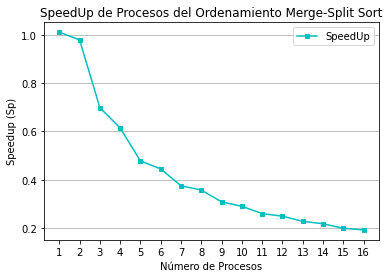

In [ ]:
speedup_ms = tiempo_secuencial / tiempos_ms

fig, ax = plt.subplots()

ax.plot(procesos,speedup_ms,marker='s',label='SpeedUp',markersize=4,color='c')

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Speedup (Sp)')
plt.title('SpeedUp de Procesos del Ordenamiento Merge-Split Sort')

plt.legend()
plt.savefig('SpeedUp_Merge_Split.png')
plt.show()

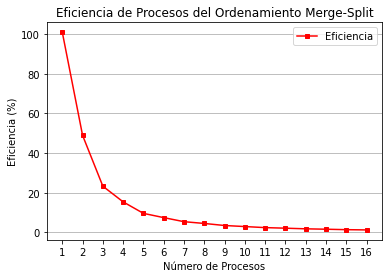

In [ ]:
eficiencia_ms = speedup_ms / procesos * 100

fig, ax = plt.subplots()

ax.plot(procesos,eficiencia_ms,marker='s',label='Eficiencia',markersize=4,color='r')

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Eficiencia (%)')
plt.title('Eficiencia de Procesos del Ordenamiento Merge-Split')

plt.legend()
plt.savefig('Eficiencia_Merge_Split.png')
plt.show()

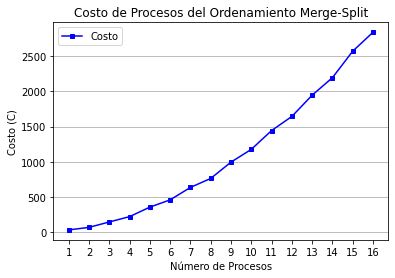

In [ ]:
costo_ms = tiempos_ms * procesos

fig, ax = plt.subplots()

ax.plot(procesos,costo_ms,marker='s',label='Costo',markersize=4,color='b')

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Costo (C)')
plt.title('Costo de Procesos del Ordenamiento Merge-Split')

plt.legend()
plt.savefig('Costo_Merge_Split.png')
plt.show()

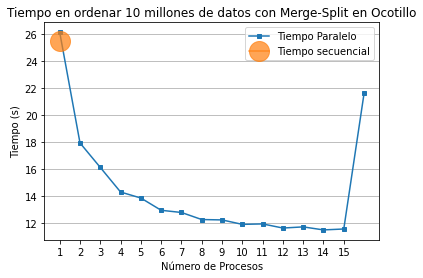

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
tiempo_secuencial = 25.480898

procesos = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
tiempos_ms = np.array([26.1315932908,17.9420599493,16.1313092355,14.3112047658,13.8667749547,
                       12.9602878942,12.7982997230,12.2759715541,12.2481125380,11.9189763618,
                       11.9519427306,11.6470923107,11.7321722265,11.5082967862,11.5764610816,21.6099367324]) 


fig, ax = plt.subplots()
ax.plot(procesos,tiempos_ms,marker='s',label='Tiempo Paralelo',markersize=4)

ax.plot([1],[tiempo_secuencial],marker='o',markersize=20,alpha=0.7,label='Tiempo secuencial')
ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('Número de Procesos')
plt.ylabel('Tiempo (s)')
plt.title('Tiempo en ordenar 10 millones de datos con Merge-Split en Ocotillo')

plt.legend()
plt.savefig('Tiempos_Merge_Split_Paralelo.png')
plt.show()

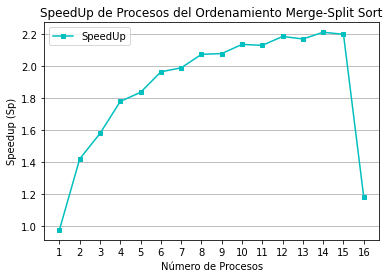

In [ ]:
speedup_ms = tiempo_secuencial / tiempos_ms
#print(speedup)
fig, ax = plt.subplots()

ax.plot(procesos,speedup_ms,marker='s',label='SpeedUp',markersize=4,color='c')

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Speedup (Sp)')
plt.title('SpeedUp de Procesos del Ordenamiento Merge-Split Sort')

plt.legend()
plt.savefig('SpeedUp_Merge_Split_Paralelo.png')
plt.show()

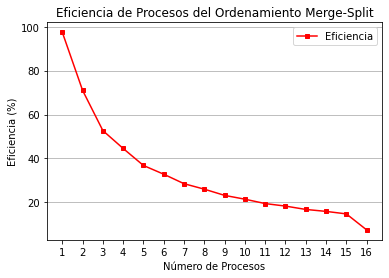

In [ ]:
eficiencia_ms = speedup_ms / procesos * 100

fig, ax = plt.subplots()

ax.plot(procesos,eficiencia_ms,marker='s',label='Eficiencia',markersize=4,color='r')

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Eficiencia (%)')
plt.title('Eficiencia de Procesos del Ordenamiento Merge-Split')

plt.legend()
plt.savefig('Eficiencia_Merge_Split_Paralelo.png')
plt.show()

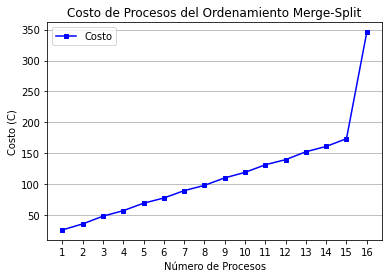

In [ ]:
costo_ms = tiempos_ms * procesos

fig, ax = plt.subplots()

ax.plot(procesos,costo_ms,marker='s',label='Costo',markersize=4,color='b')

ax.yaxis.grid(True)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
plt.xlabel('Número de Procesos')
plt.ylabel('Costo (C)')
plt.title('Costo de Procesos del Ordenamiento Merge-Split')

plt.legend()
plt.savefig('Costo_Merge_Split_Paralelo.png')
plt.show()